# Загрузка данных


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Data/quora_question_pairs_rus.csv")

In [ ]:
df = df[:1000]
print(df.shape)

(1000, 4)


In [ ]:
df.head()

,Unnamed: 0,question1,question2,is_duplicate
0,0,Какова история кохинор кох-и-ноор-бриллиант,"что произойдет, если правительство Индии украд...",0
1,1,как я могу увеличить скорость моего интернет-с...,как повысить скорость интернета путем взлома ч...,0
2,2,"почему я мысленно очень одинок, как я могу это...","найти остаток, когда математика 23 ^ 24 матема...",0
3,3,которые растворяют в воде быстро сахарную соль...,какая рыба выживет в соленой воде,0
4,4,астрология: я - луна-колпачок из козерога и кр...,Я тройная луна-козерог и восхождение в козерог...,1


# Предобработка данных

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 9.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 25.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.18.0



In [ ]:
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/distilrubert-base-cased-conversational'

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/538 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, question1, question2, targets, tokenizer, max_len):
    self.question1 = question1
    self.question2 = question2	
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.question1)
  
  def __getitem__(self, item):
    question1 = str(self.question1[item])
    question2 = str(self.question2[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      question1,
      question2,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      pad_to_max_length=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'question1': question1,
      'question2': question2,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

NameError: ignored

Разделим данные на обучающую, тестовую и валидационную выборки

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((800, 4), (100, 4), (100, 4))

Для обработки данных нам также нужно будет создать итераторы 
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    question1=df.question1.to_numpy(),
    question2=df.question2.to_numpy(),
    targets=df.is_duplicate.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
MAX_LEN = 160

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Классификация с использованием модели BERT от Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational were not used when initializing BertModel: ['vocab_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'vocab_transform.weight', 'distilbert.transformer.layer.2.attention.out_lin.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.out_lin.weight', 'distilbert.transformer.layer.5.attention.out_lin.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.

In [ ]:
df.loc[16]['question1']

'почему девушки хотят дружить с парнем, которого они отвергают'

In [ ]:
question1 = df.loc[16]['question1']
question2 = df.loc[16]['question2']

In [ ]:
encoding = tokenizer.encode_plus(
  question1,
  question2,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  #truncation= 'longest_first',
  return_tensors='pt',  # Вернуть тензор PyTorch
)

In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)['last_hidden_state']

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'почему', 'девушки', 'хотят', 'дружить', 'с', 'парнем', ',', 'которого', 'они', 'отверг', '##а', '##ют', '[SEP]', 'как', 'ребята', 'чувствуют', 'себя', 'после', 'отказа', 'от', 'девушки', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
print(len(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])))

32


In [ ]:
encoding['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [ ]:
class_names = ['not_duplicate', 'duplicate']

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational were not used when initializing BertModel: ['vocab_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'vocab_transform.weight', 'distilbert.transformer.layer.2.attention.out_lin.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.out_lin.weight', 'distilbert.transformer.layer.5.attention.out_lin.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

# Обучение модели

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#transformers.logging.set_verbosity_error()

In [ ]:
%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Epoch 1/10
----------
Train loss 0.72999587059021 accuracy 0.56875
Val   loss 0.6722385968480792 accuracy 0.63

Epoch 2/10
----------
Train loss 0.6927857983112335 accuracy 0.58
Val   loss 0.6659953849656242 accuracy 0.63

Epoch 3/10
----------
Train loss 0.7012450277805329 accuracy 0.57625
Val   loss 0.6694398096629551 accuracy 0.63

Epoch 4/10
----------
Train loss 0.6853757208585739 accuracy 0.585
Val   loss 0.6673435057912555 accuracy 0.63

Epoch 5/10
----------
Train loss 0.6932098317146301 accuracy 0.57125
Val   loss 0.66977687392916 accuracy 0.63

Epoch 6/10
----------
Train loss 0.6785578203201293 accuracy 0.61375
Val   loss 0.6664681690079826 accuracy 0.63

Epoch 7/10
----------
Train loss 0.677053970694542 accuracy 0.595
Val   loss 0.6665566393307277 accuracy 0.63

Epoch 8/10
----------
Train loss 0.6766784489154816 accuracy 0.6025
Val   loss 0.6659457002367292 accuracy 0.63

Epoch 9/10
----------
Train loss 

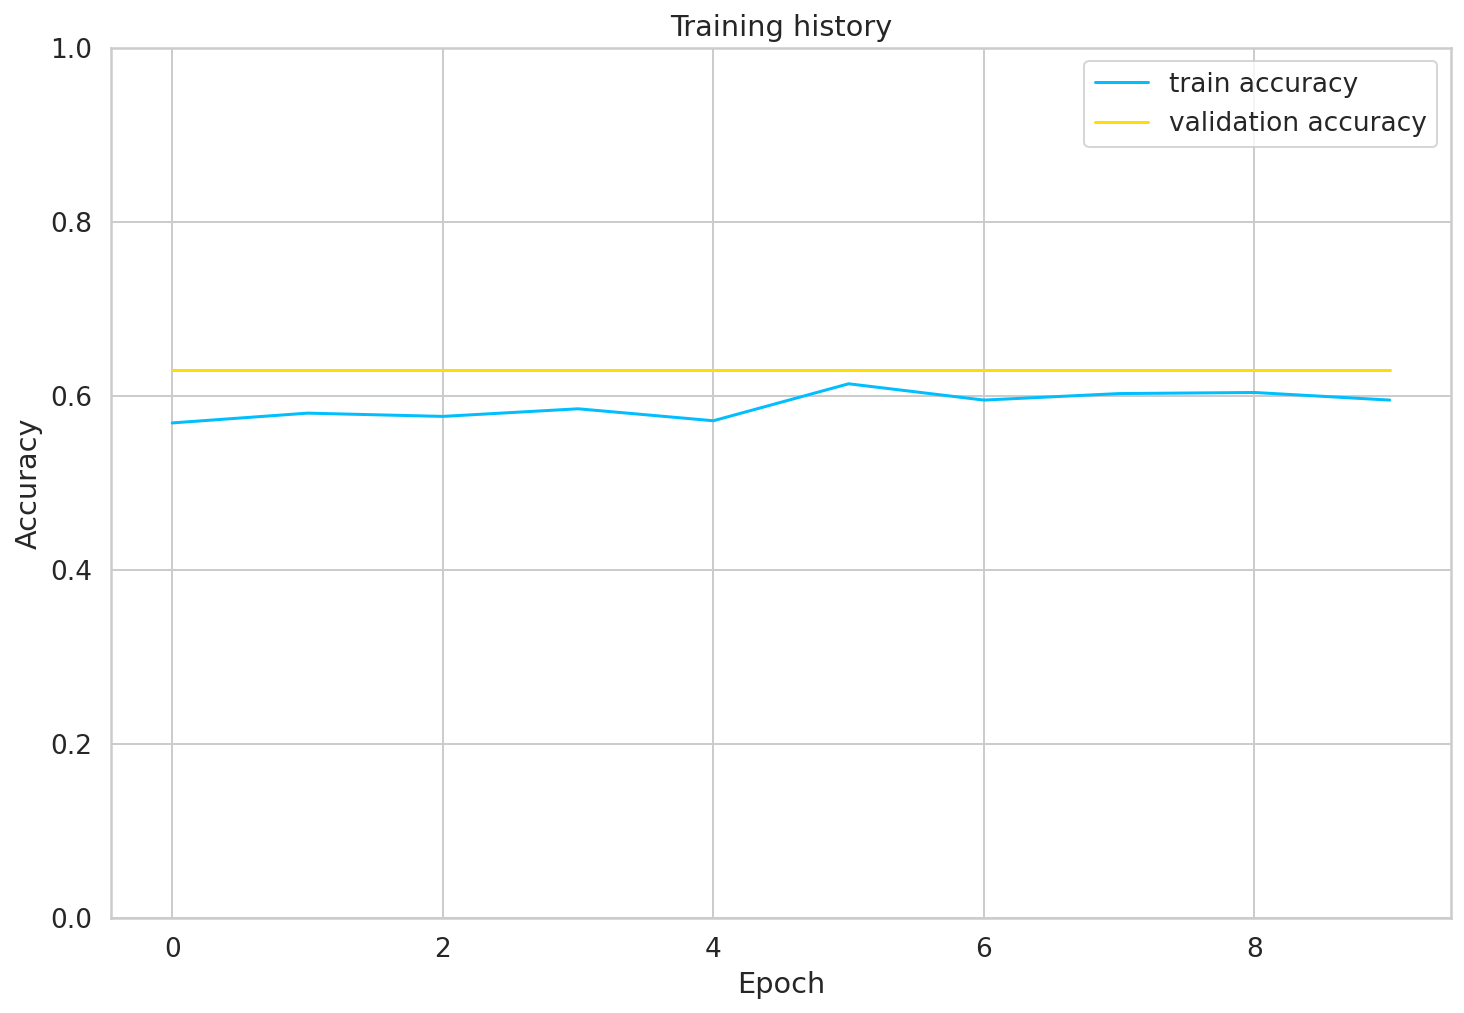

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Оценка результатов

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.65